# Feature Engineering

In [1]:
import os
import sys
import shutil
import pprint
from pathlib import Path

from random import random, randint
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifacts
from sklearn.ensemble import RandomForestRegressor
from mlflow.tracking import MlflowClient

import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split

sys.path.append(str(Path.cwd().parent))
from settings.params import PARAMS, SEED
from src.load_all_dataset import load_all_dataset
from src.utils import reduce_memory_usage
from src.datasets import *

init_notebook_mode(connected=True)
import cufflinks as cf

cf.go_offline()
import pickle
import gc
import lightgbm as lgb

warnings.filterwarnings('ignore')
%matplotlib inline
import plotly.io as pio

pio.renderers.default = "colab"
from loguru import logger
import pendulum
import sys

In [2]:
# Set logging format
log_fmt = "<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | <cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
logger.configure(handlers=[{"sink": sys.stderr, "format": log_fmt}])

# current date
CURRENT_DATE = pendulum.now(tz="UTC")

In [3]:
DIR = PARAMS['file_directory']

In [4]:
train_data = pd.read_csv(DIR + 'train_data_final.csv', index_col=0)

In [5]:
# def feature_selection(X, y, params, test_size=0.15, random_state=42, importance_threshold=50):
#     """
#     Selects the most important features using a LightGBM classifier.

#     Args:
#         X (pd.DataFrame): The feature matrix.
#         y (pd.Series): The target vector.
#         params (dict): The dictionary of parameters for the LightGBM classifier.
#         test_size (float): The proportion of the dataset to include in the validation split.
#         random_state (int): Controls the shuffling applied to the data before applying the split.
#         importance_threshold (int): The threshold for feature importance to select features.

#     Returns:
#         list: A list of selected feature names.
#     """
#     # Split the data into training and validation sets
#     train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

#     # Initialize the LightGBM classifier with the given parameters
#     model = lgb.LGBMClassifier(**params)

#     # Train the model
#     model.fit(train_features, train_y, eval_set=[(valid_features, valid_y)], eval_metric='auc')

#     # Get feature importances
#     feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns)), columns=['Value', 'Feature'])
#     features_df = feature_imp.sort_values(by="Value", ascending=False)

#     # Select features based on the importance threshold
#     selected_features = list(features_df[features_df['Value'] >= importance_threshold]['Feature'])

#     print('The number of features selected:', len(selected_features))

#     # Feature importance Plot
#     data1 = features_df.head(20)
#     data = [go.Bar(x =data1.sort_values(by='Value')['Value'] , y = data1.sort_values(by='Value')['Feature'], orientation = 'h',
#                   marker = dict(
#             color = 'rgba(43, 13, 150, 0.6)',
#             line = dict(
#                 color = 'rgba(43, 13, 150, 1.0)',
#                 width = 1.5)
#         )) ]
#     layout = go.Layout(
#         autosize=False,
#         width=1300,
#         height=700,
#         title = "Top 20 important features",
#         xaxis=dict(
#             title='Importance value'
#             ),
#         yaxis=dict(
#             automargin=True
#             ),
#         bargap=0.4
#         )
#     fig = go.Figure(data = data, layout=layout)
#     fig.layout.template = 'seaborn'
#     py.iplot(fig)

#     return selected_features

# # Example usage:
# params = {
#     'boosting_type': 'gbdt',
#     'max_depth': 7,
#     'learning_rate': 0.01,
#     'n_estimators': 2000,
#     'class_weight': 'balanced',
#     'subsample': 0.9,
#     'colsample_bytree': 0.8,
#     'n_jobs': -1
# }

# selected_features = feature_selection(X_train, y_train, params, test_size=0.15, random_state=42, importance_threshold=50)

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif


def feature_selection(train_data, params=None):
    """
    Selects the most important features using SelectKBest.

    Args:
        train_data (pd.DataFrame): The input DataFrame containing the features and target.
        params (dict): Dictionary of parameters for the feature selection.

    Returns:
        tuple: A tuple containing:
            - features_top_df_train (pd.DataFrame): DataFrame with selected features for training.
            - features_top_df_cv (pd.DataFrame): DataFrame with selected features for validation.
    """

    if params is None:
        params = {'k': 250}  # Number of top features to select

    # Extract features and target
    X_data_train = train_data.drop(['TARGET'], axis=1)
    Y_data_train = train_data['TARGET']

    # Split the data
    X_train_final, X_cv_final, Y_train_final, Y_cv_final = train_test_split(
        X_data_train, Y_data_train, test_size=0.20, stratify=Y_data_train, random_state=42
    )

    # Initialize SelectKBest with parameters from the dictionary
    k = params.get('k', 200)
    S = SelectKBest(f_classif, k=k)

    # Transform the data
    X_train_k_best = S.fit_transform(X_train_final, Y_train_final)
    X_cv_k_best = S.transform(X_cv_final)

    # Get columns to keep
    cols = S.get_support(indices=True)

    # Create new DataFrames with selected features
    features_top_df_train = X_train_final.iloc[:, cols]
    features_top_df_cv = X_cv_final.iloc[:, cols]

    # Obtenir les scores des features
    feature_scores = pd.DataFrame({'Feature': X_train_final.columns, 'Score': S.scores_})

    # Trier les features par score
    top_features = feature_scores.sort_values(by='Score', ascending=False).head(20)

    # Tracer les scores des 20 features les plus importantes
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Score', y='Feature', data=top_features, palette='viridis')
    plt.title('Top 20 Features by ANOVA F-value')
    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.show()

    # # Feature importance Plot
    # data1 = features_top_df_train.head(20)
    # data = [go.Bar(x =data1.sort_values(by='Value')['Value'] , y = data1.sort_values(by='Value')['Feature'], orientation = 'h',
    #               marker = dict(
    #         color = 'rgba(43, 13, 150, 0.6)',
    #         line = dict(
    #             color = 'rgba(43, 13, 150, 1.0)',
    #             width = 1.5)
    #     )) ]
    # layout = go.Layout(
    #     autosize=False,
    #     width=1300,
    #     height=700,
    #     title = "Top 20 important features",
    #     xaxis=dict(
    #         title='Importance value'
    #         ),
    #     yaxis=dict(
    #         automargin=True
    #         ),
    #     bargap=0.4
    #     )
    # fig = go.Figure(data = data, layout=layout)
    # fig.layout.template = 'seaborn'
    # py.iplot(fig)
    return features_top_df_train, features_top_df_cv, Y_train_final, Y_cv_final

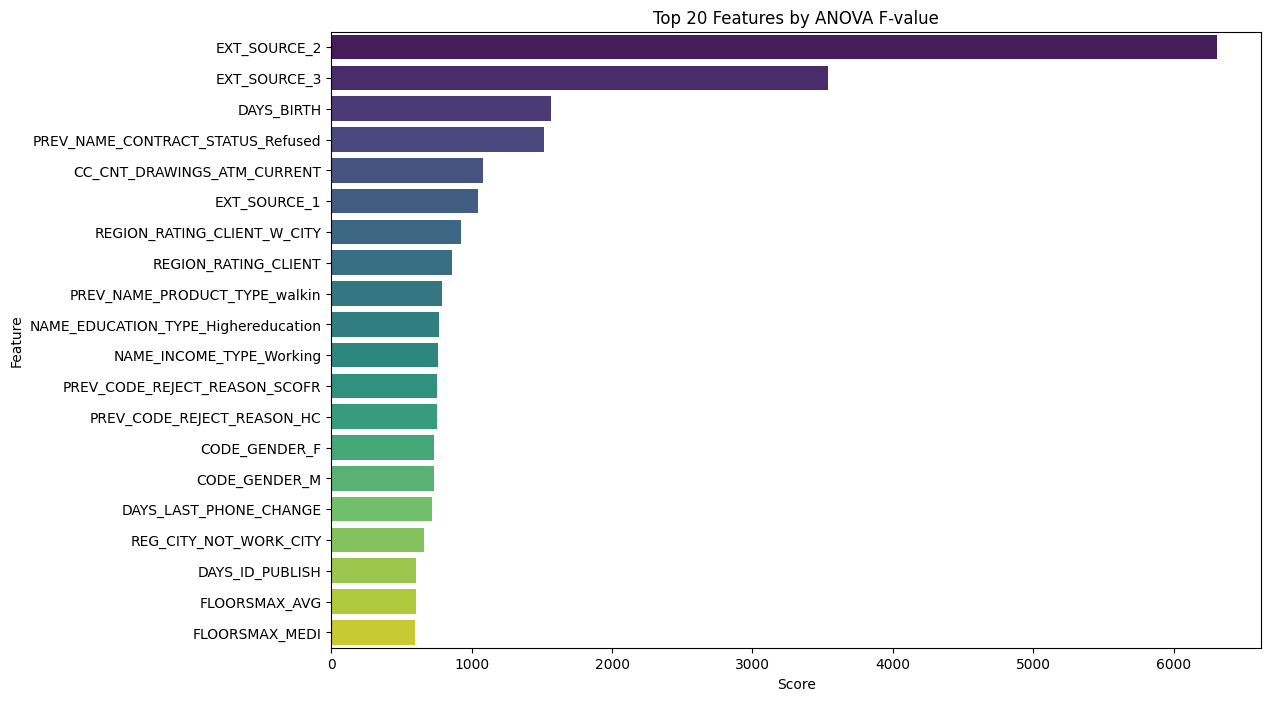

In [7]:
X_train, X_test, y_train, y_test = feature_selection(train_data)

In [8]:
def define_pipeline(
    numerical_transformer: list, categorical_transformer: list, target_transformer, classifier: Pipeline, **kwargs: dict
) -> Pipeline:
    """Define pipeline for modeling

    Args:
        **kwargs:

    Returns:
        Pipeline: sklearn pipeline
    """
    numerical_transformer = make_pipeline(*numerical_transformer)

    categorical_transformer = make_pipeline(*categorical_transformer)

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, make_column_selector(dtype_include=["number"])),
            ("cat", categorical_transformer, make_column_selector(dtype_include=["object", "bool"])),
        ],
        remainder="drop",  # non-specified columns are dropped
        verbose_feature_names_out=False,  # will not prefix any feature names with the name of the transformer
    )

    model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])

    # logger.info(f"{model_pipe}")
    return model_pipe

In [9]:
from typing import Union, Dict
from sklearn.metrics import log_loss, f1_score, roc_auc_score, recall_score, precision_score


def eval_metrics(
    y_actual: Union[pd.DataFrame, pd.Series, np.ndarray],
    y_pred: Union[pd.DataFrame, pd.Series, np.ndarray],
    y_pred_proba: Union[pd.DataFrame, pd.Series, np.ndarray],
) -> Dict[str, float]:
    """Compute evaluation metrics for classification models.

    Args:
        y_actual: Ground truth (correct) target values.
        y_pred: Estimated target values.
        y_pred_proba: Predicted probabilities for the positive class.

    Returns:
        Dict[str, float]: dictionary of evaluation metrics.
            Expected keys are: "log_loss", "f1", "auc", "recall", "precision"
    """
    # Ensure y_actual, y_pred, and y_pred_proba are numpy arrays
    y_actual = np.array(y_actual)
    y_pred = np.array(y_pred)
    y_pred_proba = np.array(y_pred_proba)

    # Calculate Log Loss
    logloss = log_loss(y_actual, y_pred_proba)

    # Calculate F1 Score
    f1 = f1_score(y_actual, y_pred, zero_division=0)

    # Calculate AUC
    auc = roc_auc_score(y_actual, y_pred_proba)

    # Calculate Recall
    recall = recall_score(y_actual, y_pred, zero_division=0)

    # Calculate Precision
    precision = precision_score(y_actual, y_pred, zero_division=0)

    # Return a dictionary
    return {"log_loss": logloss, "f1": f1, "auc": auc, "recall": recall, "precision": precision}

# Tracking

In [10]:
warnings.filterwarnings("ignore")
print(mlflow.__version__)

2.15.1


In [11]:
# # Set the tracking server to be localhost with sqlite as tracking store
# local_registry = "sqlite:///mlruns.db"
# print(f"Running local model registry={local_registry}")
# model_name = "home-default-credit-risk"
# mlflow.set_tracking_uri(local_registry)
# with mlflow.start_run(run_name="LOCAL_REGISTRY") as run:
#     params = {"n_estimators": 3, "random_state": 0}
#     sk_learn_rfr = RandomForestRegressor(params)

#     # Log parameters and metrics using the MLflow API
#     mlflow.log_params(params)
#     log_param("param_1", randint(0, 100))
#     log_metric("metric_1", random())
#     log_metric("metric_2", random() + 1)
#     log_metric("metric_3", random() + 2)

#     # Log and register the model at the same time
#     mlflow.sklearn.log_model(
#         sk_model=sk_learn_rfr, artifact_path="sklearn-model", registered_model_name="home-default-credit-risk"
#     )
#     if not os.path.exists("outputs"):
#         os.makedirs("outputs")
#     with open("outputs/test.txt", "w") as f:
#         f.write("Looks, like I logged to the local store!")
#     log_artifacts("outputs")
#     shutil.rmtree('outputs')
#     run_id = run.info.run_uuid

In [12]:
# client = MlflowClient()
# #
# # transition model stage to production
# #
# client.transition_model_version_stage(name='home-default-credit-risk', version=1, stage="production")

# # Get a list of all registered models
# print("List of all registered models")
# print("=" * 80)
# # [print(pprint.pprint(dict(rm), indent=4)) for rm in client.list_registered_models()]

# # Get a list of specific versions of the named models
# print(f"List of Model = home-default-credit-risk and Versions")
# print("=" * 80)
# [pprint.pprint(dict(mv), indent=4) for mv in client.search_model_versions("name='home-default-credit-risk'")]

In [13]:
# # run tracking UI in the background
# get_ipython().system_raw("mlflow ui --backend-store-uri sqlite:///mlruns.db --port 5000 &")# run tracking UI in the background

In [14]:
# from pyngrok import ngrok

# # Terminate open tunnels if they exist
# ngrok.kill()

# # Setting the authtoken (optional)
# NGROK_AUTH_TOKEN = "2iY7so8olRpJ0i7EhHIw9jFeDDh_2xzCxkXDqFqi2934xAym5"  # Replace with your actual ngrok auth token
# ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# # Open an HTTPs tunnel on port 5000 for http://localhost:5000
# public_url = ngrok.connect(5000, bind_tls=True)
# print("MLflow Tracking UI:", public_url)

In [15]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

In [17]:
# Create an experiment if not exists
exp_name = "home-credit-default-risk"
experiment = mlflow.get_experiment_by_name(exp_name)
if not experiment:
    experiment_id = mlflow.create_experiment(exp_name)
else:
    experiment_id = experiment.experiment_id

logger.info(f"Experience id: {experiment_id}")

2024-08-07 18:16:37.926 | INFO     | __main__:<module>:9 - Experience id: 924699276792283991


In [18]:
CLASSIFIER_PARAMS = {
    RandomForestClassifier.__name__: {
        "classifier": RandomForestClassifier,
        "params": {"n_estimators": 30, "max_depth": 3, "random_state": 42, "class_weight": "balanced"},
    },
    LogisticRegression.__name__: {
        "classifier": LogisticRegression,
        "params": {
            "penalty": "l2",  # Regularization type
            "C": 1.0,  # Inverse of regularization strength
            "random_state": 42,
            "max_iter": 1000,
            "class_weight": "balanced",
        },
    },
    lgb.LGBMClassifier.__name__: {
        "classifier": lgb.LGBMClassifier,
        "params": {
            'learning_rate': 0.05,
            'max_depth': 10,
            'n_estimators': 200,
            'num_leaves': 50,
            'is_unbalanced': True,
        },
    },
}

In [ ]:
for model_name, model_configs in CLASSIFIER_PARAMS.items():
    logger.info(f"{model_name} \n{model_configs}")

    classifier = model_configs["classifier"]
    params = model_configs["params"]

    # Useful for multiple runs (only doing one run in this sample notebook)
    with mlflow.start_run(
        run_name=f"{CURRENT_DATE.strftime('%Y%m%d_%H%m%S')}-house_price-{model_name}",
        experiment_id=experiment_id,
        tags={"version": "v1", "priority": "P1"},
        description="house price modeling",
    ) as mlf_run:
        logger.info(f"run_id: {mlf_run.info.run_id}")
        logger.info(f"version tag value: {mlf_run.data.tags.get('version')} -------------------------------")

        # log parameters
        mlflow.log_params(params)

        # Model definition
        clas = define_pipeline(
            numerical_transformer=[SimpleImputer(strategy="median"), RobustScaler()],
            categorical_transformer=[
                SimpleImputer(strategy="constant", fill_value="undefined"),
                OneHotEncoder(drop="if_binary", handle_unknown="ignore"),
            ],
            target_transformer=False,
            classifier=classifier(**params),
        )

        clas.fit(X_train, y_train)

        # mlflow.shap.log_explanation(clas.predict, X_test)

        # Predict probabilities for AUC and Log Loss
        y_train_pred_proba = clas.predict_proba(X_train)[:, 1]  # Probability of the positive class
        y_test_pred_proba = clas.predict_proba(X_test)[:, 1]  # Probability of the positive class

        # Evaluate Metrics
        y_train_pred = clas.predict(X_train)
        y_test_pred = clas.predict(X_test)
        train_metrics = eval_metrics(y_train, y_train_pred, y_train_pred_proba)
        test_metrics = eval_metrics(y_test, y_test_pred, y_test_pred_proba)

        # log out metrics
        logger.info(f"Train: {train_metrics}")
        logger.info(f"Test: {test_metrics}")

        # Infer model signature with a sample
        predictions = clas.predict(X_train[:30])
        signature = mlflow.models.infer_signature(X_train[:30], predictions)

        # Log  metrics, and model to MLflow
        mlflow.log_metrics(test_metrics)
        mlflow.sklearn.log_model(
            clas, artifact_path=clas[-1].__class__.__name__, signature=signature, input_example=X_train[:30]
        )

2024-08-07 16:43:14.765 | INFO     | __main__:<module>:2 - RandomForestClassifier 
{'classifier': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'params': {'n_estimators': 30, 'max_depth': 3, 'random_state': 42, 'class_weight': 'balanced'}}
2024-08-07 16:43:14.936 | INFO     | __main__:<module>:14 - run_id: ec170b1489394282ae0b4860f59d0c77
2024-08-07 16:43:14.937 | INFO     | __main__:<module>:15 - version tag value: v1 -------------------------------
2024-08-07 16:43:41.697 | INFO     | __main__:<module>:46 - Train: {'log_loss': 0.6561721063612771, 'f1': 0.24106577231227874, 'auc': 0.7153114731868859, 'recall': 0.651460221550856, 'precision': 0.14789666209419297}
2024-08-07 16:43:41.697 | INFO     | __main__:<module>:47 - Test: {'log_loss': 0.6558184754545546, 'f1': 0.24108416547788872, 'auc': 0.7150432132786166, 'recall': 0.6467270896273918, 'precision': 0.1481566926590689}


2024/08/07 16:43:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run 20240807_160826-house_price-RandomForestClassifier at: http://127.0.0.1:5000/#/experiments/924699276792283991/runs/ec170b1489394282ae0b4860f59d0c77.
2024/08/07 16:43:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/924699276792283991.
2024-08-07 16:43:46.708 | INFO     | __main__:<module>:2 - LogisticRegression 
{'classifier': <class 'sklearn.linear_model._logistic.LogisticRegression'>, 'params': {'penalty': 'l2', 'C': 1.0, 'random_state': 42, 'max_iter': 1000, 'class_weight': 'balanced'}}
2024-08-07 16:43:46.836 | INFO     | __main__:<module>:14 - run_id: 3a0bad8e494740dd84f92851188954bc
2024-08-07 16:43:46.836 | INFO     | __main__:<module>:15 - version tag value: v1 -------------------------------
2024-08-07 16:47:18.327 | INFO     | __main__:<module>:46 - Train: {'log_loss': 0.691712884883226, 'f1': 0.20133751027572264, 'auc': 0.6052404528250452, 

2024/08/07 16:47:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run 20240807_160826-house_price-LogisticRegression at: http://127.0.0.1:5000/#/experiments/924699276792283991/runs/3a0bad8e494740dd84f92851188954bc.
2024/08/07 16:47:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/924699276792283991.
2024-08-07 16:47:23.112 | INFO     | __main__:<module>:2 - LGBMClassifier 
{'classifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'params': {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50, 'is_unbalanced': True}}
2024-08-07 16:47:23.291 | INFO     | __main__:<module>:14 - run_id: 9ea0fdd64a6b40069c262e5569f2af94
2024-08-07 16:47:23.291 | INFO     | __main__:<module>:15 - version tag value: v1 -------------------------------


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30607
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 250
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced


2024-08-07 16:48:08.242 | INFO     | __main__:<module>:46 - Train: {'log_loss': 0.21809853736595441, 'f1': 0.0929637526652452, 'auc': 0.8431593790383081, 'recall': 0.04939577039274924, 'precision': 0.7879518072289157}
2024-08-07 16:48:08.242 | INFO     | __main__:<module>:47 - Test: {'log_loss': 0.24113580173692162, 'f1': 0.05878984539034167, 'auc': 0.7733152514023578, 'recall': 0.031017119838872106, 'precision': 0.5620437956204379}


[LightGBM] [Warning] Unknown parameter: is_unbalanced


2024/08/07 16:48:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run 20240807_160826-house_price-LGBMClassifier at: http://127.0.0.1:5000/#/experiments/924699276792283991/runs/9ea0fdd64a6b40069c262e5569f2af94.
2024/08/07 16:48:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/924699276792283991.


[LightGBM] [Warning] Unknown parameter: is_unbalanced
